<a href="https://colab.research.google.com/github/vega2k/webscraping_ml_src/blob/master/0HousePrice_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Load Data

In [ ]:
import pandas as pd
import os

data_path = '/content/drive/My Drive/Colab Notebooks/data/house'
print(data_path)

train = pd.read_csv(os.path.join(data_path,'train.csv'))
print(train.shape)

test = pd.read_csv(os.path.join(data_path,'test.csv'))
print(test.shape)


/content/drive/My Drive/Colab Notebooks/data/house
(1460, 81)
(1459, 80)


In [ ]:
print(train.columns)
train.head()

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# set index
train.set_index('Id', inplace=True)
test.set_index('Id', inplace=True)
print(train.shape, test.shape)
len_train_df = len(train)
len_test_df = len(test)


(1460, 80) (1459, 79)


### 2. Feature Selection
* 고려해야 할 변수가 많을 땐 각 독립변수와 종속변수 간의 상관관계(Corrleation)을 검토해보는 것이 좋다.
* 모든 변수를 사용하는 것도 좋지만 그 중 좀더 의미 있는 변수만을 골라내어 모델을 구축하는 것이 모델의 예측 정확도를 높이는 방법이다.
* corr()함수를 통해 dataframe내의 모든 변수간의 상관관계를 그린 후 상관관계가 0.3이상인 변수만 heatmap으로 출력하였다.

In [ ]:
corr_mat = train.corr()
corr_mat

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,-0.009640,0.158678,0.070948,-0.076444,-0.032148,-0.015728,-0.040751,-0.035227,0.046921,-0.088011,-0.038264,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


In [ ]:
top_corr_features = corr_mat.index[abs(corr_mat["SalePrice"])>=0.3]
top_corr_features

Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice'],
      dtype='object')

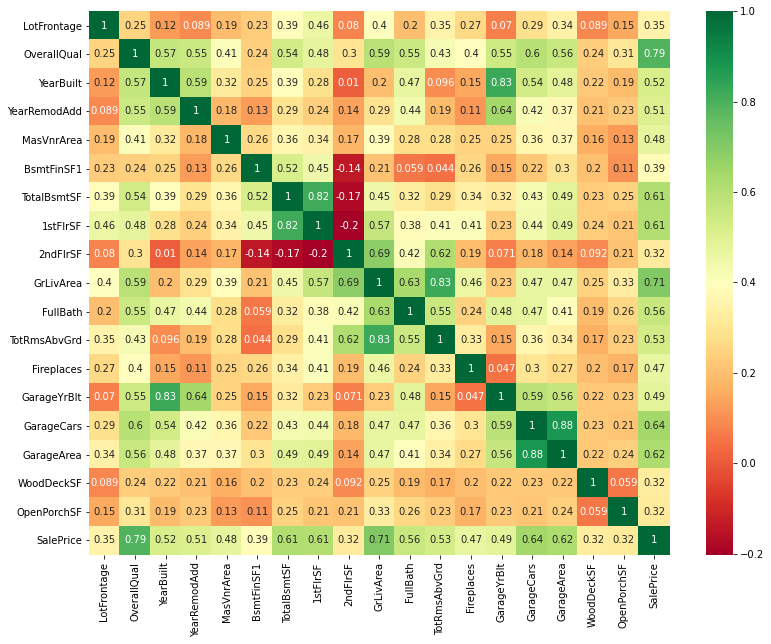

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(13,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")


In [ ]:
#(1460, 80) (1459, 79)
# split y_label
train_y_label = train['SalePrice'] 	# target 값을 미리 분리하였음.
print(train_y_label.shape)

#SalePrice 컬럼 삭제
train.drop(['SalePrice'], axis='columns', inplace=True)
print(train.shape, test.shape)

(1460,)
(1460, 79) (1459, 79)


### 3.Concat train & test set

* train과 test 셋에 동일한 feature engineering을 적용해주기 위해 우선 두개의 데이터 셋을 하나로 합쳐주었다.

In [ ]:
# concat train & test
boston_df = pd.concat((train, test), axis=0)
boston_df_index = boston_df.index

print('Length of Boston Dataset : ',len(boston_df))
print(boston_df.shape)
boston_df.head()

Length of Boston Dataset :  2919
(2919, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [ ]:
boston_df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


### 4. Check NaN ratio and Remove null ratio >= 0.5

* 데이터를 처리할 때 항상 Null값을 어떻게 처리할지 고민해야 한다. 추후 모델에 입력되는 input값에는 절대 어떠한 Null 값이 있어서는 안되며 있더라도 에러가 발생하기 때문에 미리 꼭 처리해주어야 한다.
* 각 칼럼별로 Null값 비율이 50%이상인 칼럼을 찾아 해당 칼럼을 제거해주었다.

In [ ]:
boston_df.isna().sum()

MSSubClass         0
MSZoning           4
LotFrontage      486
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 79, dtype: int64

In [ ]:
# check null 
check_null = boston_df.isna().sum() / len(boston_df)

check_null

MSSubClass       0.000000
MSZoning         0.001370
LotFrontage      0.166495
LotArea          0.000000
Street           0.000000
                   ...   
MiscVal          0.000000
MoSold           0.000000
YrSold           0.000000
SaleType         0.000343
SaleCondition    0.000000
Length: 79, dtype: float64

In [ ]:
# columns of null ratio >= 0.5
check_null[check_null >= 0.5]

Alley          0.932169
PoolQC         0.996574
Fence          0.804385
MiscFeature    0.964029
dtype: float64

In [ ]:
# remove columns of null ratio >= 0.5
# Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')
remove_cols = check_null[check_null >= 0.5].index
remove_cols

Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [ ]:
boston_df = boston_df.drop(remove_cols, axis='columns')
boston_df.shape

(2919, 75)

### 5.Check Object & Numeric variables
* 카테고리형 데이터는 각 칼럼을 0과 1로 변환해주는 one-hot encoding을 적용해주어 수치값과 가중치를 달리해주어야 한다.
* 수치형 데이터와 카테고리형 데이터를 구분하기 위해 select_dtypes()를 이용하였다. parameter값으로 include와 exclude를 적용할 수 있는데 이를 통해 데이터를 분리한다.

In [ ]:
# split object & numeric
# 카테고리형
boston_obj_df = boston_df.select_dtypes(include='object')	
# 수치형
boston_num_df = boston_df.select_dtypes(exclude='object')	

print(boston_obj_df.shape, boston_num_df.shape)

(2919, 39) (2919, 36)


In [ ]:
print('Object type columns:\n',boston_obj_df.columns)
print('---------------------------------------------------------------------------------')
print('Numeric type columns:\n',boston_num_df.columns)

Object type columns:
 Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')
---------------------------------------------------------------------------------
Numeric type columns:
 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFul

### 6. Change object type to dummy variables
* 카테고리형 데이터에 one-hot encoding을 적용하기 위해 pandas의 pd.get_dummies()를 적용
* get_dummies() 의 drop_first=True는 인코딩 컬럼들 중 제일 첫번째 컬럼을 삭제한다는 의미

In [ ]:
# (2919, 39) => (2919, 200)
boston_dummy_df = pd.get_dummies(boston_obj_df, drop_first=True)

print(boston_dummy_df.shape)

(2919, 200)


### 7. Impute NaN of numeric data to ‘mean’
* 각 칼럼의 null값을 해당하는 각 변수들의 평균(mean)으로 대체(imputation)해주었다.
* 평균값 대체를 위하여 scikit-learn의 SimpleImputer 함수를 이용하였으며, strategy 값에 대체해주고자 하는 이름을 넣어주면 해당 값으로 처리한다.

In [ ]:
boston_num_df.isnull().sum().sort_values(ascending=False)

LotFrontage      486
GarageYrBlt      159
MasVnrArea        23
BsmtHalfBath       2
BsmtFullBath       2
GarageArea         1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
GarageCars         1
OverallCond        0
YearBuilt          0
YearRemodAdd       0
OverallQual        0
GrLivArea          0
LotArea            0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
YrSold             0
MoSold             0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MSSubClass         0
dtype: int64

In [ ]:

import numpy as np
from sklearn.impute import SimpleImputer  
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer.fit(boston_num_df)
boston_num_df_ = imputer.transform(boston_num_df)

boston_num_df_

array([[6.0000e+01, 6.5000e+01, 8.4500e+03, ..., 0.0000e+00, 2.0000e+00,
        2.0080e+03],
       [2.0000e+01, 8.0000e+01, 9.6000e+03, ..., 0.0000e+00, 5.0000e+00,
        2.0070e+03],
       [6.0000e+01, 6.8000e+01, 1.1250e+04, ..., 0.0000e+00, 9.0000e+00,
        2.0080e+03],
       ...,
       [2.0000e+01, 1.6000e+02, 2.0000e+04, ..., 0.0000e+00, 9.0000e+00,
        2.0060e+03],
       [8.5000e+01, 6.2000e+01, 1.0441e+04, ..., 7.0000e+02, 7.0000e+00,
        2.0060e+03],
       [6.0000e+01, 7.4000e+01, 9.6270e+03, ..., 0.0000e+00, 1.1000e+01,
        2.0060e+03]])

In [ ]:
boston_num_df = pd.DataFrame(boston_num_df_, columns=boston_num_df.columns, index=boston_df_index)
print(boston_num_df.shape)
boston_num_df.isnull().sum().sort_values(ascending=False)

(2919, 36)


YrSold           0
MoSold           0
GrLivArea        0
LowQualFinSF     0
2ndFlrSF         0
1stFlrSF         0
TotalBsmtSF      0
BsmtUnfSF        0
BsmtFinSF2       0
BsmtFinSF1       0
MasVnrArea       0
YearRemodAdd     0
YearBuilt        0
OverallCond      0
OverallQual      0
LotArea          0
LotFrontage      0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
WoodDeckSF       0
MiscVal          0
PoolArea         0
ScreenPorch      0
3SsnPorch        0
EnclosedPorch    0
OpenPorchSF      0
GarageArea       0
HalfBath         0
GarageCars       0
GarageYrBlt      0
Fireplaces       0
TotRmsAbvGrd     0
KitchenAbvGr     0
BedroomAbvGr     0
MSSubClass       0
dtype: int64

### 8. Merge numeric_df & dummies_df
* 카테고리형 데이터와 수치형 데이터를 이제 최종적으로 다시 하나로 merge해준다.
* merge시 index 순서가 꼬이지 않게 left_index=True, right_index=True를 지정하여 merge를 수행한다.


In [ ]:
# boston_dummy_df : 500 개, boston_num_df : 36
boston_df = pd.merge(boston_dummy_df, boston_num_df, left_index=True, right_index=True)
print(boston_df.shape)
boston_df.head()

(2919, 236)


,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0
2,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0
3,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,2001.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0
4,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,7.0,1.0,1998.0,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0
5,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,9.0,1.0,2000.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0


### 9. Split train & validation & test set
* 모델 학습 및 검증을 위해 데이터를 split한다.
* 검증을 위해 validation set을 train set의 20%만큼을 지정해주었다.
* 최종적으로 1460개의 train set를 1,168개의 데이터로 학습 및 292개의 데이터로 검증 후 1,459개의 test셋을 예측한다.

In [ ]:
len_train_df

1460

In [ ]:
# SettingWithCopyWarning의 발생을 예방하기 위한 가장 쉬운 방법은 파생 DataFrame에 copy() 메서드를 실행해, 
# 원천 DataFrame과 별도인 메모리 공간을 파생 DataFrame에 부여하는 것이 좋다

In [ ]:
train = boston_df[:len_train_df].copy()
test = boston_df[len_train_df:].copy()

train['SalePrice'] = train_y_label

print(train.shape)
print(test.shape)

(1460, 237)
(1459, 236)


In [ ]:
from sklearn.model_selection import train_test_split

X_train = train.drop(['SalePrice'], axis=1)
y_train = train['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

X_test = test
test_id_idx = test.index

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape)

(1168, 236) (1168,)
(292, 236) (292,)
(1459, 236)


### 10. Training by XGBRegression Model
* 모델 학습을 위해 최근 kaggle에서 가장 인기 있는 모델인 XGBoost 모델을 이용하였다. 해당 예측은 regression 예측이므로 XGBRegressor() 모델을 이용하였다.
* 최적의 모델 파라미터 설정을 위하여 GridSearch를 이용하였으며, 5번의 cross-validation으로 검증
* https://statkclee.github.io/model/model-python-xgboost-hyper.html

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param = {
    'max_depth':[2,3,4],
    'n_estimators':range(550,700,50),
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'colsample_bylevel': 0.7, 'colsample_bytree': 0.7, 'max_depth': 3, 'n_estimators': 550}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=550,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


### 11. Prediction & Score
* validation mae 값이 14,000정도인데, 워낙 집 가격에 대한 값의 범위가 넓기 때문에 이 정도 error값은 심각한 정도는 아님

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
pred_train = grid_search.predict(X_train)
pred_val = grid_search.predict(X_val)

print('train mae score: ', mean_absolute_error(y_train, pred_train))
print('val mae score:', mean_absolute_error(y_val, pred_val))

print('train mae score: ', mean_squared_error(y_train, pred_train))
print('val mae score:', mean_squared_error(y_val, pred_val))

train mae score:  4976.087251846105
val mae score: 14611.680998501712
train mae score:  44859996.978131376
val mae score: 506915290.45628494


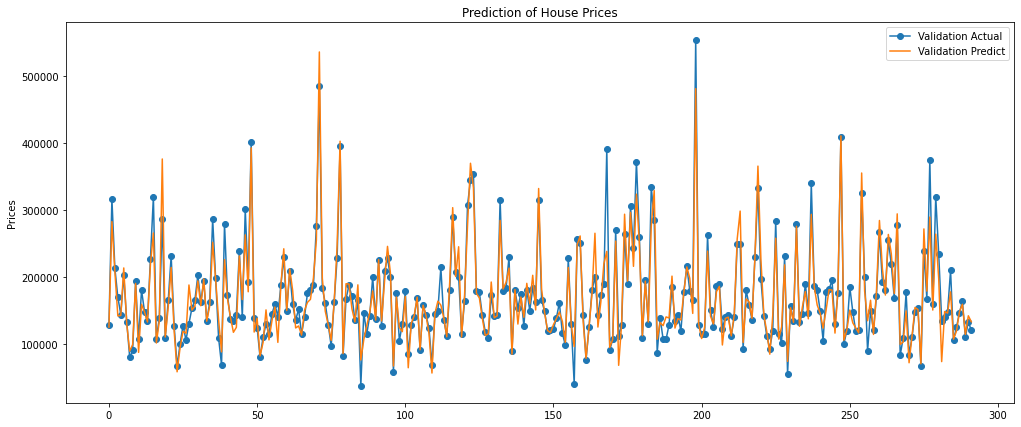

In [ ]:
plt.figure(figsize=(17,7))
plt.plot(range(0, len(y_val)), y_val,'o-', label='Validation Actual')
plt.plot(range(0, len(pred_val)), pred_val, '-', label='Validation Predict')
plt.title('Prediction of House Prices')
plt.ylabel('Prices')
plt.legend()

### 12. Predict test set & Submit submission.csv


In [ ]:
test_y_pred = grid_search.predict(X_test)
test_y_pred

array([124706.766, 173314.64 , 189989.27 , ..., 147359.31 , 118217.195,
       216612.08 ], dtype=float32)

In [ ]:
id_pred_df = pd.DataFrame()
id_pred_df['Id'] = test_id_idx
id_pred_df['SalePrice'] = test_y_pred


In [ ]:
id_pred_df.to_csv(os.path.join(data_path,'submission.csv'), index=False)


In [ ]:
X_train = train.drop(['SalePrice'], axis=1)
y_train = train['SalePrice']

X_test = test
test_id_idx = test.index

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape)



(1460, 236) (1460,)
(292, 236) (292,)
(1459, 236)


In [ ]:
# regressor = xgb.XGBRegressor(colsample_bytree = 0.4603, learning_rate = 0.06, min_child_weight = 1.8,
#                                  max_depth= 3, subsample = 0.52, n_estimators = 2000,
#                                  random_state= 7, ntrhead = -1,objective='reg:squarederror')

#{'colsample_bylevel': 0.7, 'colsample_bytree': 0.7, 'max_depth': 3, 'n_estimators': 550}
regressor = xgb.XGBRegressor(colsample_bylevel = 0.7, colsample_bytree = 0.7, learning_rate = 0.06, min_child_weight = 1.8,
                                 max_depth= 3, subsample = 0.52, n_estimators = 2000,
                                 random_state= 7, ntrhead = -1,objective='reg:squarederror')
regressor.fit(X_train,y_train)

predictions = regressor.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)
score = accuracies.mean()
print(score)

0.8904498102526517


In [ ]:
id_pred_df = pd.DataFrame()
id_pred_df['Id'] = test_id_idx
id_pred_df['SalePrice'] = predictions

In [ ]:
file_name = f'submission_{score}.csv'
id_pred_df.to_csv(os.path.join(data_path,file_name), index=False)